# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [1]:
import tensorflow as tf
tf.enable_eager_execution()
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
import numpy as np
import math
from matplotlib.pyplot import figure
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import glob

C:\Users\Usuario\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Leemos los datos

In [2]:
def clean_data_test(data):
    data.dropna(how="all", inplace=True)
    data = data.set_index(data.iloc[0::,0], drop=True, append=False, inplace=False, verify_integrity=False)
    data.columns = data.iloc[0]
    data = data.drop("Fecha", axis=1)
    if "Fecha" in data.index: data.drop("Fecha", axis = 0, inplace=True)
    data.columns.name = "Prices"
    data.index.name = "Dates"
    return data

def clean_data(data):
    data = pd.read_excel(data_path + filenames[16], header=2, parse_col="A:Z")
    return data

In [3]:
data_path = "datos/precios/"
filenames = os.listdir(data_path)
filenames = [e for e in filenames if e[0] != '~']

In [4]:
data = pd.read_excel(data_path + filenames[0], header=2, usecols="A:Y")

iterfiles = iter(filenames) 
next(iterfiles)

for f in iterfiles:
    data = data.append(pd.read_excel(data_path + f, header=2, usecols="A:Y"), ignore_index=True)
data = data.drop("Fecha", axis=1)
print(data)

               0           1           2           3           4           5  \
0            NaN    1.073000    1.073000    1.073000    1.073000    1.073000   
1       1.073000    1.000000    1.000000    1.000000    1.000000    1.000000   
2       1.073000    1.073000    1.000000    1.000000    1.000000    1.073000   
3       1.073000    1.000000    1.000000    1.000000    1.000000    1.000000   
4       1.000000    1.000000    0.990000    1.000000    1.000000    1.073000   
5       0.990000    0.990000    0.989000    0.990000    0.990000    1.073000   
6       0.500000    0.500000    0.500000    0.500000    0.500000    0.990000   
7       0.500000    0.500000    0.500000    0.500000    0.500000    0.500000   
8       0.000000    0.000000    0.000000    0.000000    0.000000    0.463000   
9       1.000000    1.000000    0.000000    0.000000    1.000000    0.000000   
10      1.072000    1.000000    0.000000    0.000000    0.000000    0.000000   
11      0.000000    0.000000    0.000000

De esta forma tenemos los datos pero hay algunas casillas con NaN los cuales habra que eliminar

# Normalizamos lo datos

Procedemos a eliminar los valores "NaNs", no son necesarios y como no son un porcentaje muy alto del valor total de los datos (2.83% de los datos totales), es seguro hacer este procedimiento.

    

In [5]:
nans = sum(pd.isnull(data).sum().values)
nans_per = 1 - (len(data.index) - nans) / len(data.index)
print("El porcentaje de los NaNs es: " + str(nans_per * 100) + "%")
data.dropna(how="any", inplace=True)
data.reset_index(drop=True)

print(data)

El porcentaje de los NaNs es: 2.830300868117497%
               0           1           2           3           4           5  \
1       1.073000    1.000000    1.000000    1.000000    1.000000    1.000000   
2       1.073000    1.073000    1.000000    1.000000    1.000000    1.073000   
3       1.073000    1.000000    1.000000    1.000000    1.000000    1.000000   
4       1.000000    1.000000    0.990000    1.000000    1.000000    1.073000   
5       0.990000    0.990000    0.989000    0.990000    0.990000    1.073000   
6       0.500000    0.500000    0.500000    0.500000    0.500000    0.990000   
7       0.500000    0.500000    0.500000    0.500000    0.500000    0.500000   
8       0.000000    0.000000    0.000000    0.000000    0.000000    0.463000   
9       1.000000    1.000000    0.000000    0.000000    1.000000    0.000000   
10      1.072000    1.000000    0.000000    0.000000    0.000000    0.000000   
11      0.000000    0.000000    0.000000    0.000000    0.000000    1.0

Como podemos ver, ya los datos NaNs no estan y podemos calcular el promedio

In [6]:
mean_prices = data.sum(axis=1) / (len(data.columns))

Ahora aplicaremos la transformacion log y la transformacion exponencial

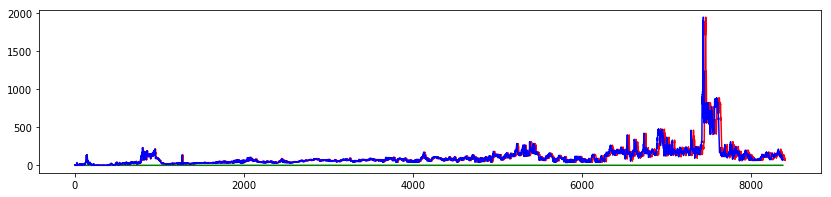

In [7]:
plt.figure(figsize=(14,3))

def scale_data(data, fx = None, c = -1, d = 1):
    
    if fx != None:
        out = fx(data.values)
    else:
        out = data.values
    out = out.tolist()
    b = max(out)
    a = min(out)
    out = [c + ((d-(c))/(b-a))*(e-a) for e in out]
    return out, a, b

def de_scale_data(s_data, a, b, inv_fx = None, c = -1, d = 1):
    p = (d-c)/(b-a)
    out = [(y + (p*a) -c)/p for y in s_data]
    if inv_fx != None:
        out = inv_fx(out)
    return out

d, a, b = scale_data(mean_prices, np.log)
ds = de_scale_data(d, a, b, np.exp)

plt.plot(d, color='green');
plt.plot(mean_prices, color = 'red')
plt.plot(ds, color = 'blue')


Como podemos ver las 2 transformaciones tienen un comportamiento parecido, ahora miraremos el modelo sin transformar

In [8]:
class Model(object):
    
    def __init__(self, L):
        self.w = tf.contrib.eager.Variable([0.0] * (L+1))
        self.errs = []
    def __call__(self, x):
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred
                             
    def fit(self, mu, x, y_desired):
        y_pred = self(x)
        e = y_desired - y_pred
        self.errs.append(e)
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Mean error of the scaled data is tf.Tensor(0.00042976183, shape=(), dtype=float32)


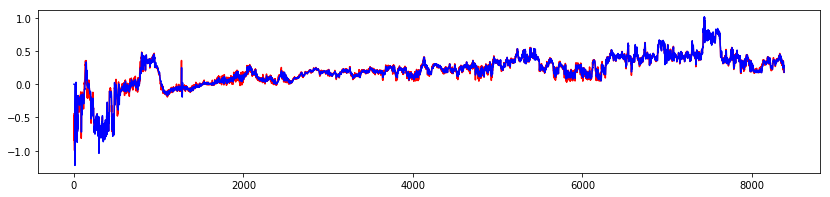

In [9]:
L = 11
model = Model(L)

y_pred = np.empty(len(d))
y_pred[:] = 0

for t in range(L, len(d)):
    x = d[t-L:t]                        
    y_pred[t] = model(x)
    #print(model(x))
    model.fit(mu=0.09, x=x, y_desired=d[t])


MSE = sum(model.errs)**2 / len(model.errs)
print("Mean error of the scaled data is " + str(MSE))
plt.figure(figsize=(14,3))
plt.plot(d, color='red');
plt.plot(y_pred, color = 'blue');

Miramos cual tasa de aprendizaje y cuantos valores previos son los ideales

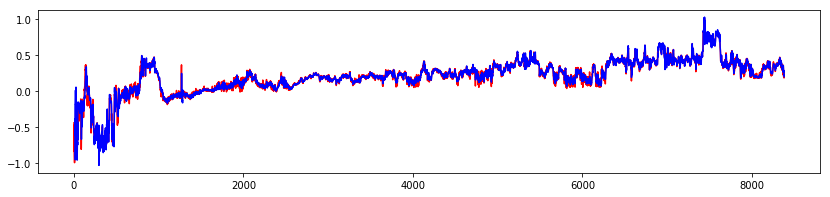

In [10]:
## mu es la tasa de aprendizaje (escogida arbitrariamente)
mu = 0.07

## Para pronosticar el valor actual se toman los `L` 
## valores previos de la serie
L = 15

## Los pesos iniciales del ADALINE son 
## fijados arbitrariamente
## w es un vector columna
w = np.array(0.1 * np.random.standard_normal(L+1)).reshape(L+1, 1)


y_pred = np.zeros(len(d))
y_pred[0:L] = np.nan
for t in range(L, len(d)):
    x = np.array([1] + d[t-L:t]) ## entrada al ADALINE
    x = x.reshape(len(x), 1)
    p = w.T @ x                  ## pronostico
    y_pred[t] = p
    
    ## algoritmo de aprendizaje
    e = d[t] - p
    w = w + 2 * mu * e * x

plt.figure(figsize=(14,3))
plt.plot(d, color='red');
plt.plot(y_pred, color = 'blue');

Luego de realizar diferentes pruebas se llega a la conclusion de que numeros muy altos de aprendizaje tampoco son ideales, el optimo esta entre 12-15 y la tasa de aprendizaje optima esta entre 0.05 y 0.07. de esta forma se pega bastante al modelo la prediccion y de esta forma predecimos los ultimos 7 dias


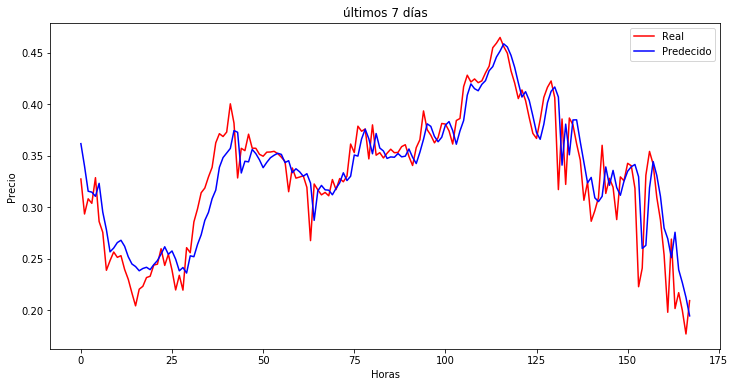

In [11]:
def imprimir(real,predic,trans):

    figure(figsize=(12,6))
    plt.plot(real, color = 'red', label = 'Real')
    plt.plot(predic, color = 'blue', label = 'Predecido')
    plt.title(trans)
    plt.xlabel('Horas')
    plt.ylabel('Precio')
    plt.legend()
    return plt.show()

def adaline(retar,tasa_apren,d):
    retardo = retar

    model = Model(retardo)

    y_pred = np.empty(len(d))
    y_pred[:] = np.nan

    for t in range(retardo, len(d)):
        x = d[t-retardo:t]
        y_pred[t] = model(x)
        model.fit(mu=tasa_apren, x=x, y_desired=d[t])
    return [d[-(168):],y_pred[-(168):]]
    
modelo_sin_transf = adaline(15,0.06,d)

imprimir(modelo_sin_transf[0],modelo_sin_transf[1],"últimos 7 días")

Como podemos ver como el modelo tiene muchos picos al principio no suele pegarse a ellos muy bien pero luego cada vez se va pegando cada vez mas a los datos reales